In [2]:
# pandas
import pandas as pd
from pandas import Series,DataFrame
from datetime import datetime as datetime
import re as re
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
df = pd.read_csv('Bookings per stashpoint prediciton.csv')  
df['activated'] = pd.to_datetime(df['activated'] , errors='coerce')

# Filter to only include stashpoints in the UK (country == 'GBR')
df = df[df['country'] == 'GBR'].copy()

df.head()

,stashpoint_id,bookings_90d,business_name,country,type,capacity,activated,sps_within_500m,units_supply_within_500m,review_count_90d,avg_review_rating_90d,searches_last_90
3,21ee810bc764,2,Foodwise Express,GBR,convenience_store,50,2024-11-06,24,1355,0,NaN,7958
5,6f169b288d15,3,Foodwise Local,GBR,convenience_store,10,2025-05-29,24,1395,0,NaN,7953
9,08b673bc5584,113,Europa House Hotel,GBR,hotel,200,2023-07-26,23,1156,4,4.75,4388
11,5c806eaca40c,11,Sonic Paddington Souvenirs,GBR,luggage_storage_shop,100,2025-03-05,23,1255,0,NaN,7925
13,b612231f182c,3,Mail Boxes Etc,GBR,postal_shop,50,2020-05-25,23,1305,0,NaN,7946


In [4]:
print(df.columns.tolist()) 

['stashpoint_id', 'bookings_90d', 'business_name', 'country', 'type', 'capacity', 'activated', 'sps_within_500m', 'units_supply_within_500m', 'review_count_90d', 'avg_review_rating_90d', 'searches_last_90']


In [5]:
# list of unique locations type 
#print(df['type'].value_counts())
# Group some of them 

type_mapping = {
    # Hospitality
    'hotel': 'hospitality',
    'hostel': 'hospitality',
    'premier_inn_hotel': 'hospitality',
    'staycity_hotel': 'hospitality',
    'wilde_aparthotel': 'hospitality',
    'yha_hostel': 'hospitality',
    'marriott_courtyard_hotel': 'hospitality',
    'concordia_boutique_hotel': 'hospitality',
    'sofitel_hotel': 'hospitality',
    'ihg_crowne_plaza_hotel': 'hospitality',

    # Retail
    'shop': 'retail',
    'convenience_store': 'retail',
    'tech_shop': 'retail',
    'postal_shop': 'retail',
    'luggage_storage_shop': 'retail',
    'rental_shop': 'retail',
    'souvenir_shop': 'retail',
    'newsagent': 'retail',
    'smoke_shop': 'retail',

    # Food & Beverage
    'food_and_beverage_business': 'food',
    'restaurant': 'food',
    'cafe': 'food',

    # Services
    'office': 'services',
    'health_beauty_business': 'services',
    'laundry_business': 'services',

    # Utility
    'car_park': 'utility',

    # Locker
    'locker': 'locker'
}

# Apply grouping
df['type_grouped'] = df['type'].map(type_mapping).fillna('other')
print(df['type_grouped'].value_counts())

type_grouped
locker         952
retail         380
hospitality    378
services       120
food            99
utility          1
Name: count, dtype: int64


In [6]:
# One-hot encode 'type_grouped' and drop the original column
df = pd.get_dummies(df, columns=['type_grouped'], prefix='type', drop_first=True)

In [7]:
# Drop non needed 
df.drop(['country', 'type'], axis=1, inplace=True)

In [8]:
## Additional variables 

today = pd.Timestamp.today()
df['age_in_days'] = (today - df['activated']).dt.days

# Competition density (stashpoints per unit) (removed as v weak correlation) 
df['competition_density'] = df['sps_within_500m'] / (df['units_supply_within_500m'] + 1)

# Search to supply ratio
df['search_to_supply_ratio'] = df['searches_last_90'] / (df['units_supply_within_500m'] + 1)

In [9]:
# Dealing with too many missings

missing_pct = df.isnull().mean().sort_values(ascending=False)
#print(missing_pct)

zero_pct = (df == 0).mean(numeric_only=True).sort_values(ascending=False)
#print(zero_pct)


In [10]:
threshold_missing = 0.3 # Remove if > 30% missing 
threshold_zero = 0.8 # remove if > 80% are 0

cols_to_drop = missing_pct[missing_pct > threshold_missing].index.tolist()
cols_to_drop += zero_pct[zero_pct > threshold_zero].index.tolist()
cols_to_drop = list(set(cols_to_drop))  # remove duplicates

print("Columns to consider dropping:", cols_to_drop)

Columns to consider dropping: ['type_hospitality', 'avg_review_rating_90d', 'type_utility', 'type_services', 'review_count_90d', 'type_retail']


In [11]:
df.drop(['review_count_90d', 'avg_review_rating_90d'], axis=1, inplace=True)

In [12]:
df.head() 

,stashpoint_id,bookings_90d,business_name,capacity,activated,sps_within_500m,units_supply_within_500m,searches_last_90,type_hospitality,type_locker,type_retail,type_services,type_utility,age_in_days,competition_density,search_to_supply_ratio
3,21ee810bc764,2,Foodwise Express,50,2024-11-06,24,1355,7958,False,False,True,False,False,243,0.017699,5.868732
5,6f169b288d15,3,Foodwise Local,10,2025-05-29,24,1395,7953,False,False,True,False,False,39,0.017192,5.696991
9,08b673bc5584,113,Europa House Hotel,200,2023-07-26,23,1156,4388,True,False,False,False,False,712,0.019879,3.792567
11,5c806eaca40c,11,Sonic Paddington Souvenirs,100,2025-03-05,23,1255,7925,False,False,True,False,False,124,0.018312,6.309713
13,b612231f182c,3,Mail Boxes Etc,50,2020-05-25,23,1305,7946,False,False,True,False,False,1869,0.017611,6.084227


In [14]:
# Step 1: Build the feature set
features = [
    'capacity',
    'age_in_days',
    'searches_last_90',
    'sps_within_500m',
    'units_supply_within_500m',
    'search_to_supply_ratio',
]

# Add the encoded 'type_grouped' columns (anything starting with 'type_')
type_columns = [col for col in df.columns if col.startswith('type_')]
features += type_columns

X_seg = df[features].copy()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)

In [18]:
segment_summary = df.groupby('segment').agg({
    'bookings_90d': ['count', 'mean'],
    'capacity': 'mean',
    'searches_last_90': 'mean',
    'age_in_days': 'mean',
    'sps_within_500m': 'mean',
    'units_supply_within_500m': 'mean',
    'search_to_supply_ratio': 'mean',
    **{col: 'mean' for col in type_columns}  # avg presence of each type
})

 
print(segment_summary)

        bookings_90d               capacity searches_last_90  age_in_days  \
               count        mean       mean             mean         mean   
segment                                                                     
0                509   24.662083  42.442043       848.950884   642.667976   
1                978    4.607362   0.806748        38.335378   132.865031   
2                 84  219.023810  67.738095     10925.904762   865.678571   
3                359   70.679666  19.183844       610.345404  1173.579387   

        sps_within_500m units_supply_within_500m search_to_supply_ratio  \
                   mean                     mean                   mean   
segment                                                                   
0              4.618861               168.422397              17.980440   
1              0.689162                 5.073620               3.880502   
2             14.285714               824.440476              18.858022   
3         

In [27]:
# Step 1: Filter numeric columns for profiling
profile_cols = [
    'capacity', 'age_in_days', 'searches_last_90',
    'sps_within_500m', 'units_supply_within_500m',
    'search_to_supply_ratio'
] + [col for col in df.columns if col.startswith('type_')]

# Step 2: Keep only numeric columns
numeric_profile_cols = df[profile_cols].select_dtypes(include=['number', 'bool']).columns.tolist()

# Step 3: Compute segment and overall means
seg_means = df.groupby('segment')[numeric_profile_cols].mean()
overall_means = df[numeric_profile_cols].mean()

# Step 4: Compute index scores
index_scores = (seg_means / overall_means) * 100
index_scores = index_scores.round(1)

segment_means = index_scores
segment_means

,capacity,age_in_days,searches_last_90,sps_within_500m,units_supply_within_500m,search_to_supply_ratio,type_hospitality,type_locker,type_retail,type_services,type_utility
segment,,,,,,,,,,,
0,234.2,130.4,102.0,176.7,171.7,120.7,0.0,0.0,334.3,353.9,0.0
1,4.5,27.0,4.6,26.4,5.2,26.1,0.0,196.9,0.0,0.0,0.0
2,373.9,175.7,1312.6,546.5,840.3,126.6,139.8,4.8,272.1,153.2,2297.6
3,105.9,238.1,73.3,87.4,83.5,265.8,504.9,0.0,0.0,0.0,0.0


In [28]:
overall_means = segment_means.mean()

# Index scores: (segment / overall) * 100
index_scores = (segment_means / overall_means) * 100
index_scores = index_scores.round(1)
index_scores

,capacity,age_in_days,searches_last_90,sps_within_500m,units_supply_within_500m,search_to_supply_ratio,type_hospitality,type_locker,type_retail,type_services,type_utility
segment,,,,,,,,,,,
0,130.4,91.3,27.3,84.4,62.4,89.5,0.0,0.0,220.5,279.2,0.0
1,2.5,18.9,1.2,12.6,1.9,19.4,0.0,390.5,0.0,0.0,0.0
2,208.2,123.0,351.8,261.2,305.4,93.9,86.7,9.5,179.5,120.8,400.0
3,59.0,166.7,19.6,41.8,30.3,197.2,313.3,0.0,0.0,0.0,0.0


In [30]:
segment_labels = {
    0: "Retail & Service Hosts",
    1: "New Lockers, Inactive",
    2: "Large Mixed-Use Hubs",
    3: "Mature Hospitality with High Demand Efficiency"
}

index_scores['Segment Label'] = index_scores.index.map(segment_labels)
index_scores.set_index('Segment Label', inplace=True)
index_scores.to_csv("segment_index_scores_labeled.csv")

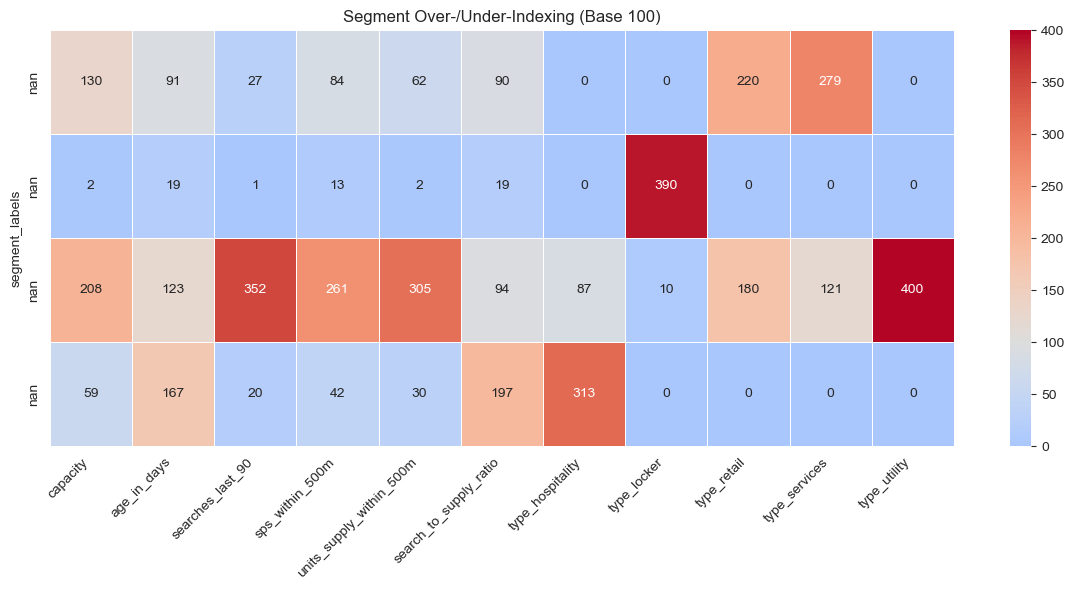

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(index_scores, cmap='coolwarm', center=100, annot=True, fmt='.0f', linewidths=0.5)
plt.title("Segment Over-/Under-Indexing (Base 100)")
plt.ylabel("segment_labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

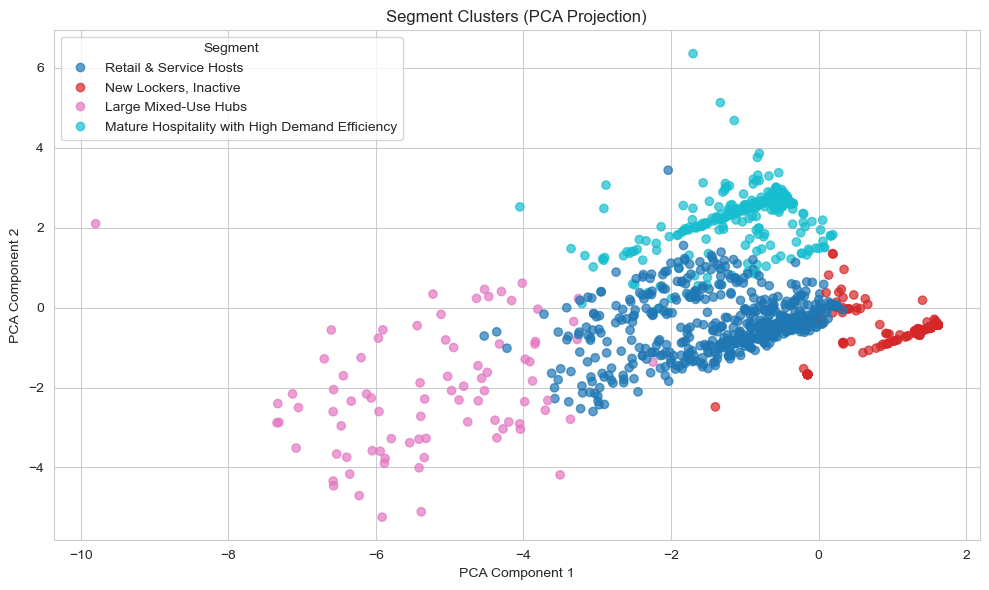

In [33]:
from sklearn.decomposition import PCA

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['segment'],
    cmap='tab10',
    alpha=0.7
)

# Add legend using mapped labels
handles, _ = scatter.legend_elements()
labels = [segment_labels[s] for s in sorted(df['segment'].unique())]
plt.legend(handles, labels, title="Segment")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Segment Clusters (PCA Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

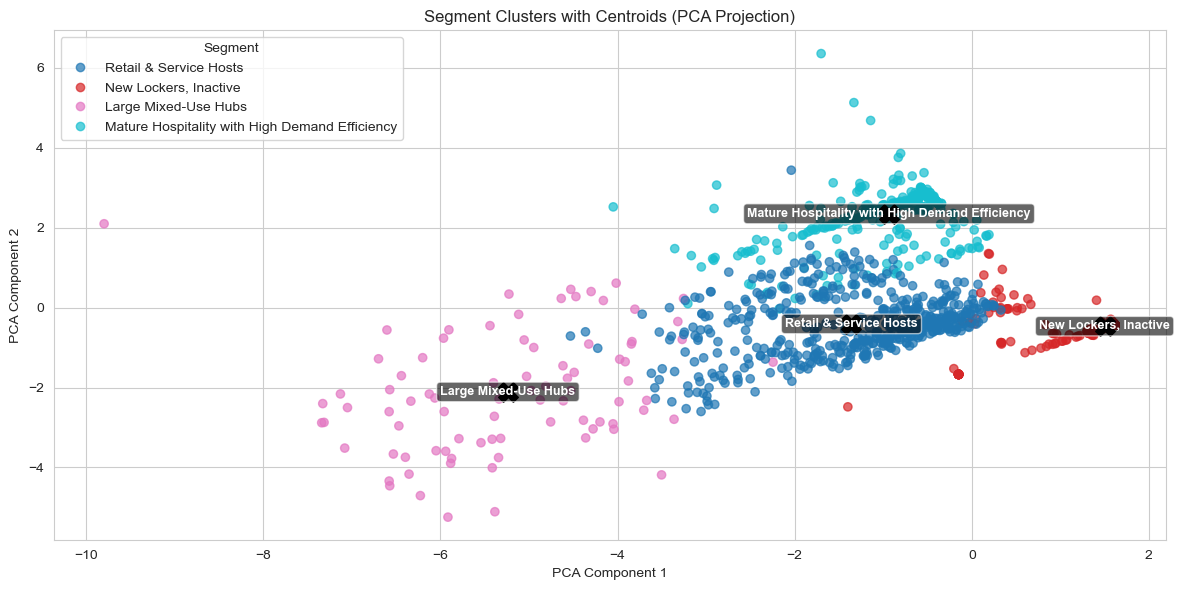

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assume:
# - `X_scaled` is your standardized feature matrix
# - `df['segment']` contains your cluster labels
# - `segment_labels` maps segment number to name
# - `pca` is already fitted
# - `X_pca` = pca.transform(X_scaled)

# 1. Compute centroids in PCA space
centroids = []
for seg in sorted(df['segment'].unique()):
    seg_mask = df['segment'] == seg
    seg_centroid = X_pca[seg_mask].mean(axis=0)
    centroids.append(seg_centroid)
centroids = np.array(centroids)

# 2. Plot with centroids
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['segment'],
    cmap='tab10',
    alpha=0.7
)

# Add centroid markers
plt.scatter(centroids[:, 0], centroids[:, 1], 
            c='black', s=200, marker='X', label='Centroids')

# Annotate centroids with segment labels
for i, (x, y) in enumerate(centroids):
    plt.text(x, y, segment_labels[i], fontsize=9, fontweight='bold', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3'))

# Add legend
handles, _ = scatter.legend_elements()
labels = [segment_labels[s] for s in sorted(df['segment'].unique())]
plt.legend(handles, labels, title="Segment", loc="best")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Segment Clusters with Centroids (PCA Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# Let's take a step back - remove types. So we can answer this question: 
# Do types naturally align with certain behavioral clusters?

In [38]:
base_features = [
    'capacity', 'age_in_days', 'searches_last_90',
    'sps_within_500m', 'units_supply_within_500m',
    'search_to_supply_ratio'
]

X = df[base_features].copy()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans (e.g., 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)

In [42]:
seg_means = df.groupby('segment')[base_features].mean()
overall_means = df[base_features].mean()
index_scores = (seg_means / overall_means) * 100
index_scores = index_scores.round(1)
index_scores

,capacity,age_in_days,searches_last_90,sps_within_500m,units_supply_within_500m,search_to_supply_ratio
segment,,,,,,
0,35.7,32.5,19.1,50.3,31.0,45.5
1,215.2,150.9,194.4,0.0,0.0,10867.0
2,332.1,160.3,1083.2,528.8,763.6,108.0
3,202.1,246.3,84.0,128.3,124.8,127.1


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

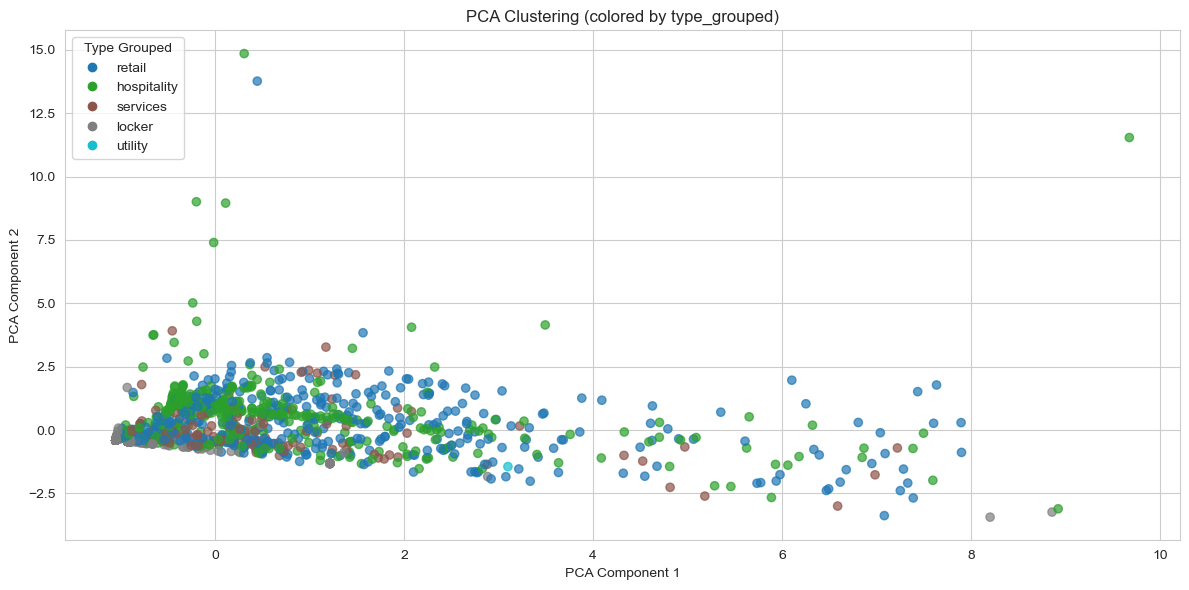

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reverse from one-hot encoding (less reliable if drop_first=True was used)
type_columns = [col for col in df.columns if col.startswith('type_')]
df['type_grouped'] = df[type_columns].idxmax(axis=1).str.replace('type_', '')

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use `type_grouped` as color
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=pd.factorize(df['type_grouped'])[0],  # Convert category to numeric
    cmap='tab10', alpha=0.7
)

# Legend for each type_grouped
unique_types = df['type_grouped'].unique()
handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)))
           for i in range(len(unique_types))]
plt.legend(handles, unique_types, title="Type Grouped")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Clustering (colored by type_grouped)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Create the cross-tab table
segment_type_ct = pd.crosstab(df['segment'], df['type_grouped'], normalize='index') * 100

# Round for readability
segment_type_ct = segment_type_ct.round(1)

# Display
print(segment_type_ct)

type_grouped  hospitality  locker  retail  services  utility
segment                                                     
0                     7.5    74.5    11.4       6.6      0.0
1                    80.0     0.0    20.0       0.0      0.0
2                    30.1     2.7    57.5       8.8      0.9
3                    63.8     0.0    31.4       4.8      0.0


In [46]:
segment_labels = {
    0: "Low-Demand Lockers",
    1: "Solo Hotels with No Competition",
    2: "High-Traffic Retail Powerhouses",
    3: "Mature Hospitality with Stable Demand"
}

In [47]:
# Add descriptive label for each stashpoint
df['segment_label'] = df['segment'].map(segment_labels)

# Optional: reorder for clarity
cols = ['stashpoint_id', 'segment', 'segment_label'] + [col for col in df.columns if col not in ['segment', 'segment_label']]
df = df[cols]

# Export
df.to_csv("stashpoints_with_segments.csv", index=False)
print("✅ Exported as 'stashpoints_with_segments.csv'")

✅ Exported as 'stashpoints_with_segments.csv'
